In [1]:
## Imports - NP, PD, SNS, SciPy, PLT, Preprocessing, ML MOdels, Metrics, Etc.
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn.externals
import matplotlib.pyplot as plt
import time
from math import sqrt
from functools import partial
from sklearn.inspection import permutation_importance
import graphviz 

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay, average_precision_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier, plot_tree, export_text

from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier, VotingClassifier
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, LogisticRegression,SGDClassifier
from sklearn.svm import SVR
#from sklearn.neighbors import KNeighborsRegressor
#from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, Normalizer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer, precision_recall_fscore_support
from sklearn.model_selection import train_test_split,  validation_curve, cross_validate, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn import tree
from sklearn.pipeline import Pipeline, make_pipeline

#from scipy import stats
#from scipy.stats import pearsonr
#from pandas_profiling import ProfileReport

#from statsmodels.stats.outliers_influence import variance_inflation_factor
#from sklearn.inspection import permutation_importance

from joblib import Parallel, parallel_backend, delayed, dump, load
#import matplotlib.ticker as mtick
#from matplotlib.ticker import PercentFormatter
#import plotly as py
#import plotly.graph_objects as go

In [2]:
## Ingest CSV files from T2 Stage - "Full" Dataset plus two condensed feature sets, multi-collinearity checked
data=pd.read_csv("Full Task2 DF.csv").drop(columns=['Unnamed: 0'])
Summary=pd.read_csv("Summary Task2 DF.csv").drop(columns=['Unnamed: 0'])
AltSummary=pd.read_csv("T2-LargerDataset.csv").drop(columns=['Unnamed: 0'])

n_jobs = 4  # The number of tasks to run in parallel
n_cpus = 2  # Number of CPUs assigned to this process

#data.info()
#Summary.info(

In [3]:
### Helper function used later for classification viz/comparison: Confusion Matrix, Predictions Distriubtion, ROC

def evalBinaryClassifier(model, x, y, labels=['Positives','Negatives']):
    '''
    Visualize the performance of  a Logistic Regression Binary Classifier.
    
    Displays a labelled Confusion Matrix, distributions of the predicted
    probabilities for both classes, the ROC curve, and F1 score of a fitted
    Binary Logistic Classifier. Author: gregcondit.com/articles/logr-charts
    
    Parameters
    ----------
    model : fitted scikit-learn model with predict_proba & predict methods
        and classes_ attribute. Typically LogisticRegression or 
        LogisticRegressionCV
    
    x : {array-like, sparse matrix}, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples
        in the data to be tested, and n_features is the number of features
    
    y : array-like, shape (n_samples,)
        Target vector relative to x.
    
    labels: list, optional
        list of text labels for the two classes, with the positive label first
        
    Displays
    ----------
    3 Subplots
    
    Returns
    ----------
    F1: float
    '''
    #model predicts probabilities of positive class
    p = model.predict_proba(x)
    if len(model.classes_)!=2:
        raise ValueError('A binary class problem is required')
    if model.classes_[1] == 1:
        pos_p = p[:,1]
    elif model.classes_[0] == 1:
        pos_p = p[:,0]
    
    #FIGURE
    plt.figure(figsize=[15,4])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y,model.predict(x))
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
              'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)
      
    #2 -- Distributions of Predicted Probabilities of both classes
    df = pd.DataFrame({'probPos':pos_p, 'target': y})
    plt.subplot(132)
    plt.hist(df[df.target==1].probPos, density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(df[df.target==0].probPos, density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(.5, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=15)
    plt.xlabel('Positive Probability (predicted)', size=13)
    plt.ylabel('Samples (normalized scale)', size=13)
    plt.legend(loc="upper right")
    
    #3 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y,p[:,1])
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='green',
             lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    #plot current decision point:
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()
    #Print and Return the F1 score
    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    printout = (
        f'Precision: {round(precision,2)} | '
        f'Recall: {round(recall,2)} | '
        f'F1 Score: {round(F1,2)} | '
    )
    print(printout)
    return F1

In [4]:
## Predicting Likelihood of Default - Iterate List of Seven Classification Algorithms & Compare Mean Accuracy
## Binary Classification of "def_next_default=[0,1]"

### Loop of classification models
Class_Algos = []
Class_Algos.append(('Random Forest', RandomForestClassifier(random_state=123)))
Class_Algos.append(('Decision Tree', DecisionTreeClassifier(random_state=123)))
Class_Algos.append(('Extra Tree', ExtraTreeClassifier(random_state=123)))
Class_Algos.append(('Bagging', BaggingClassifier(random_state=123)))
Class_Algos.append(('Stochastic_Gradient_Descent', SGDClassifier(loss='modified_huber',random_state=123)))
Class_Algos.append(('ADA Boost', AdaBoostClassifier(random_state=123)))
Class_Algos.append(('Gradient Boost',GradientBoostingClassifier(random_state=123)))

results, names, models, estimators = [], [], [], []
#models_results={"Model":[], "Mean_Acc":[], "FullCrossVal":[]}
models_results=pd.DataFrame(columns=['Model','Mean_Acc', 'ClassReport'])

##Separate initial feature-set (X) & dependent variable (y)  
## Don't adjust input CSV here unless re-slice X, y columns 
X = Summary.loc[:,'LIMIT_BAL':'High_Lev']
y = Summary['def_next_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

### Switch Preprocessing Method as Desired - Normalizer, MinMaxScaler
scaler = StandardScaler().fit(X_train)   
X_train_trans = scaler.transform(X_train)
X_test_trans = scaler.transform(X_test)

feature_names=X.columns.values

for name, model in Class_Algos:
    result = cross_val_score(model.fit(X_train_trans,y_train), X_test_trans, y_test, cv=5, scoring='accuracy') 
    print(name,result.mean())
    models_results.loc[len(models_results)] = [name,result.mean(),result]
         
print("\nMean Classification Accuracy, equal weight by models against Target Y", models_results['Mean_Acc'].mean()) ## Double check y matches desired target
print("\nFeatures used were:", feature_names)

## Preprocessing Steps Appear Relatively Unimportant
## Ytarg Avg = .765 for StandardScaler(X)
## Ytarg Avg =  .756 for unscaled X
## Ytarg Avg =  .749 for MinMaxScaler(X)
## Ytarg Avg = .758 for Normalizer(X)

Random Forest 0.7875555555555556
Decision Tree 0.7086666666666667
Extra Tree 0.7161111111111111
Bagging 0.7744444444444445
Stochastic_Gradient_Descent 0.7647777777777777
ADA Boost 0.8013333333333333
Gradient Boost 0.8006666666666667

Mean Classification Accuracy, equal weight by models against Target Y 0.7647936507936508

Features used were: ['LIMIT_BAL' 'AgeBin2' 'SEX_female' 'Debt_UsageAVG' 'Total_Paid'
 'Net_Borrow' 'PrevRel' 'EvBehind' 'AvgPayTime' 'EdRank' 'Slow_Payer'
 'High_Lev']


In [5]:
### Initial baseline established above, try fuller feature-set and separate X,y train/test as before

X = AltSummary.loc[:, AltSummary.columns != 'def_next_default'].drop(columns=['ID'])
y = AltSummary['def_next_default']

results = []
names = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

scaler = StandardScaler().fit(X_train) ### Switch Preprocessing Method as Desired
X_train_trans = scaler.transform(X_train)
X_test_trans = scaler.transform(X_test)

feature_names=X.columns.values

for name, model in Class_Algos:
    result = cross_val_score(model.fit(X_train_trans,y_train), X_test_trans, y_test, cv=5, scoring='accuracy') 
    print(name,result.mean())
    models_results.loc[len(models_results)] = [name,result.mean(),result]
         
print("\nMean Classification Accuracy, equal weight by models against Target Y", models_results['Mean_Acc'].mean()) ## Double check y matches desired target

print("\nFeatures used were:", feature_names)

## As before, specific preprocessing technique appears relatively unimportant
## Ytarg Avg = .771 for StandardScaler(X)
## Ytarg Avg =  .761 for unscaled X
## Ytarg Avg =  .764 for MinMaxScaler(X)
## Ytarg Avg = .767 for Normalizer(X)

Random Forest 0.8054444444444444
Decision Tree 0.7225555555555555
Extra Tree 0.7227777777777779
Bagging 0.7847777777777777
Stochastic_Gradient_Descent 0.7674444444444445
ADA Boost 0.8009999999999999
Gradient Boost 0.8098888888888889

Mean Classification Accuracy, equal weight by models against Target Y 0.7691031746031747

Features used were: ['LIMIT_BAL' 'PAY_2' 'PAY_6' 'BILL_AMT2' 'PAY_AMT2' 'PAY_AMT3' 'PAY_AMT4'
 'PAY_AMT5' 'PAY_AMT6' 'SEX_male' 'EDUCATION_university' 'Debt_Usage6'
 'PrevRel' 'Behind1' 'Behind3' 'Behind4' 'Behind5' 'Behind6' 'AgeBin2'
 'EdRank' 'Slow_Payer' 'High_Lev']


In [6]:
### Fit, CrossVal, Predict, Report for : Random Forest, ADA Boost, Gradient Boost, DTree and Logistic Regression
### Dumps models into own .joblib output for later use and classification_report output into own dataframe

X = AltSummary.loc[:, AltSummary.columns != 'def_next_default'].drop(columns=['ID'])
y = AltSummary['def_next_default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

scaler = StandardScaler().fit(X_train)
X_train_trans = scaler.transform(X_train)
X_test_trans = scaler.transform(X_test)
feature_names=X_train.columns.values

##Random Forest
forest=RandomForestClassifier(random_state=123, class_weight='balanced').fit(X_train_trans,y_train)
RFresults = cross_validate(forest, X_test_trans, y_test, cv=5, return_train_score=True,
                        scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc'])
Fpredictions=forest.predict(X_test_trans)
RFreport=pd.DataFrame(classification_report(y_test,Fpredictions, output_dict=True)).transpose()
dump(forest, "C2T3-RFClass.joblib")

## ADA Boost
ADA=AdaBoostClassifier(random_state=123).fit(X_train_trans,y_train)
ADAresults=cross_validate(ADA, X_test_trans, y_test, cv=5, return_train_score=True,
                        scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc'])
ADApredictions=ADA.predict(X_test_trans)
ADAreport=pd.DataFrame(classification_report(y_test,ADApredictions, output_dict=True)).transpose()
dump(ADA, "C2T3-ADAClass.joblib")

##Gradient Boost
GB=GradientBoostingClassifier(random_state=123).fit(X_train_trans,y_train)
GBresults=cross_validate(GB, X_test_trans, y_test, cv=5, return_train_score=True,
                         scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc'])
GBpredictions=GB.predict(X_test_trans)
GBreport=pd.DataFrame(classification_report(y_test,GBpredictions, output_dict=True)).transpose()
dump(GB, "C2T3-GBClass.joblib")

##Decision Tree Classifier
DTree=DecisionTreeClassifier(random_state=123, ## Switch Class Weighting as Desired
                             class_weight='balanced').fit(X_train_trans,y_train)
DTresults = cross_validate(DTree, X_test_trans, y_test, cv=5, return_train_score=True,
                           scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc'])
DTpredictions=DTree.predict(X_test_trans)
DTreport=pd.DataFrame(classification_report(y_test,DTpredictions, output_dict=True)).transpose()
dump(DTree, "C2T3-DTClass.joblib")

##Logistic (Binomial Regression)
LR=LogisticRegression(random_state=123, class_weight='balanced').fit(X_train_trans,y_train)
LRresults = cross_validate(LR, X_test_trans, y_test, cv=5, 
                        scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc'])
LRpredictions=LR.predict(X_test_trans)
LRreport=pd.DataFrame(classification_report(y_test,LRpredictions, output_dict=True)).transpose()
dump(LR, "C2T3-LRClass.joblib")



['C2T3-LRClass.joblib']

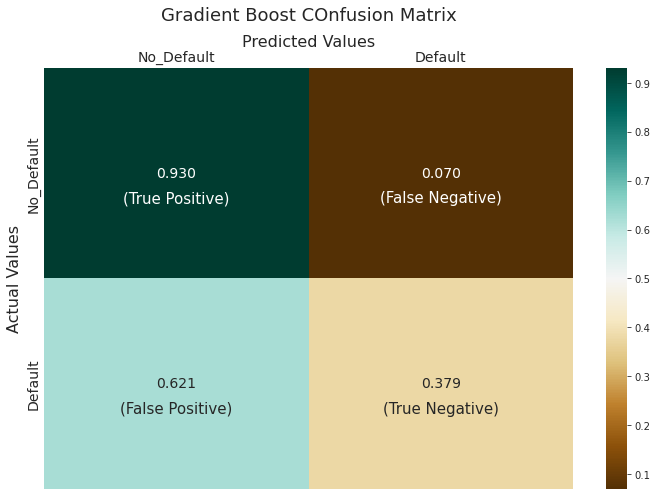

In [7]:
## Create N / % Confusion Matrixes For Each Model
Fcnf_matrix = confusion_matrix(y_test, Fpredictions)
Fcnf_matrixP = Fcnf_matrix.astype('float') / Fcnf_matrix.sum(axis=1)[:, np.newaxis]

ADAcnf_matrix = confusion_matrix(y_test, ADApredictions)
ADAcnf_matrixP = ADAcnf_matrix.astype('float') / ADAcnf_matrix.sum(axis=1)[:, np.newaxis]

GBcnf_matrix = confusion_matrix(y_test, GBpredictions)
GBcnf_matrixP = GBcnf_matrix.astype('float') / GBcnf_matrix.sum(axis=1)[:, np.newaxis]

DTcnf_matrix = confusion_matrix(y_test, DTpredictions)
DTcnf_matrixP = DTcnf_matrix.astype('float') / DTcnf_matrix.sum(axis=1)[:, np.newaxis]

LRcnf_matrix = confusion_matrix(y_test, LRpredictions)
LRcnf_matrixP = LRcnf_matrix.astype('float') / LRcnf_matrix.sum(axis=1)[:, np.newaxis]

#SeaBorn Styling
class_names=['No_Default','Default'] # name  of classes
sns.set_style("whitegrid")
sns.color_palette("mako", as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 7))

## Comment/Uncomment Lines for SPecific Model Heatmap
sns.heatmap(GBcnf_matrixP, cmap="BrBG", annot=True, fmt='.3f', xticklabels=class_names, yticklabels=class_names, ax=ax, annot_kws={"fontsize":14})
ax.set_title('Gradient Boost COnfusion Matrix', size=18, pad=14) ## Change Title Per Model, Adjust Matrix for Heatmap
#sns.heatmap(Fcnf_matrixP, cmap="BrBG", annot=True, fmt='.3f', xticklabels=class_names, yticklabels=class_names, ax=ax, annot_kws={"fontsize":14})
#sns.heatmap(ADAcnf_matrixP, cmap=cmap, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
#sns.heatmap(GBcnf_matrixP, cmap=cmap, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
#sns.heatmap(DTcnf_matrixP, cmap=cmap, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
#sns.heatmap(LRcnf_matrixP, cmap=cmap, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.tick_params(labelsize=14, length=0)

#ax.set_title('Confusion Matrix', size=18, pad=14)
ax.set_xlabel('Predicted Values', size=16)
ax.set_ylabel('Actual Values', size=16)

additional_texts = ['(True Positive)', '(False Negative)', '(False Positive)', '(True Negative)']
for text_elt, additional_text in zip(ax.texts, additional_texts):
    ax.text(*text_elt.get_position(), '\n' + additional_text, color=text_elt.get_color(),
            ha='center', va='top', size=15)
plt.tight_layout()
plt.show()

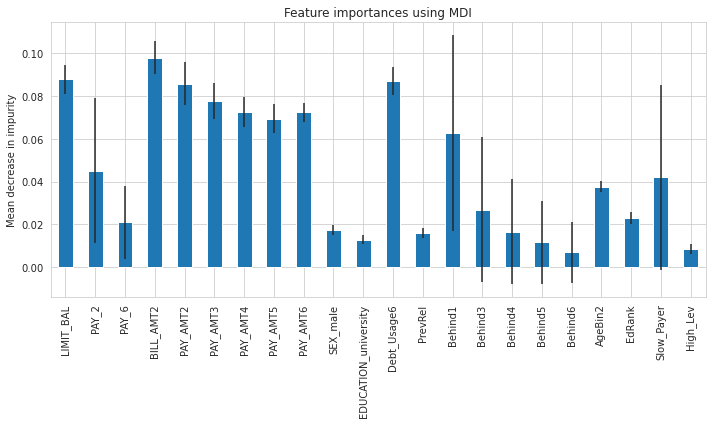

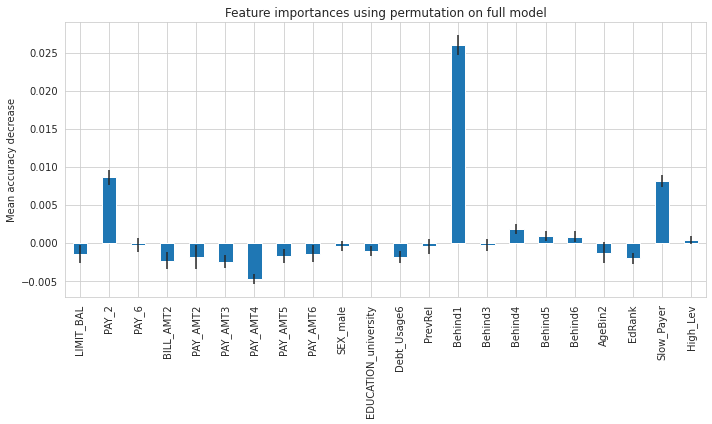

Text(0.5, 1.0, 'Decision Tree Feature Importance')

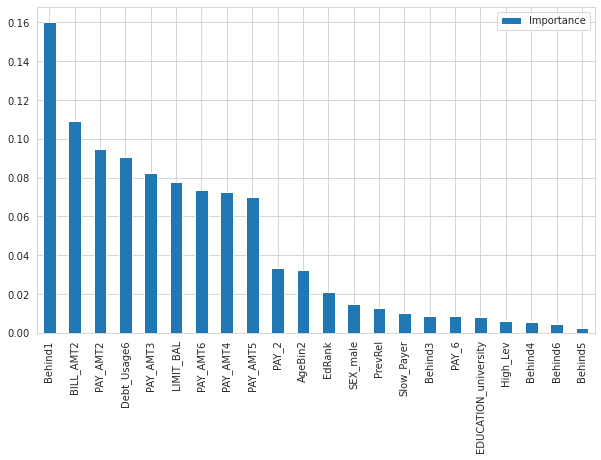

In [8]:
## Feature Importances

## RForest - Based on mean decrease in impurity
importances = forest.fit(X_train_trans,y_train).feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax, figsize=(10,6))
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
#print(forest_importances)
#forest_importances.nlargest(8).plot(kind='barh')

## RForest - Based on Permutation Importance
result = permutation_importance(forest, X_test_trans, y_test, n_repeats=10, random_state=42, n_jobs=1)
forest_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax,figsize=(10,6))
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
#print(forest_importances)
fig.tight_layout()
plt.show()

## DTree
feat_importances = pd.DataFrame(DTree.feature_importances_, index=feature_names, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(10,6))
ax.set_title("Decision Tree Feature Importance")

In [9]:
### Ensemble Voting CLassifiers - Comparing Hard and Soft
### Estimators the 7 defined in Class_Algos, duplicates prior CPU usage :-()

## 'Hard'
VCh=VotingClassifier(estimators=Class_Algos, voting='hard').fit(X_train_trans,y_train)
VChscore = cross_val_score(VCh, X_test_trans, y_test, cv=5, scoring='accuracy').mean()
VChCV = cross_validate(VCh, X_test_trans, y_test, cv=5,  ##
                          scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                          return_train_score=True) ## Drop ROC_AUC for hard b/c no predict_proba
VChpredictions=VCh.predict(X_test_trans)
VChreport=pd.DataFrame(classification_report(y_test,VChpredictions, output_dict=True)).transpose()

## 'Soft'
VCs=VotingClassifier(estimators=Class_Algos, voting='soft').fit(X_train_trans, y_train)
VCsscore=cross_val_score(VCs, X_test_trans, y_test, cv=5, scoring='accuracy').mean() 
VCsCV = cross_validate(VCs, X_test_trans, y_test, cv=5,  ##
                          scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc'],
                          return_train_score=True) 
VCspredictions=VCs.predict(X_test_trans)
VCsreport=pd.DataFrame(classification_report(y_test,VCspredictions, output_dict=True)).transpose()

models_results.loc[len(models_results)] = ["Hard Voting", VChscore, VChreport]
models_results.loc[len(models_results)] = ["Soft Voting", VCsscore, VCsreport]

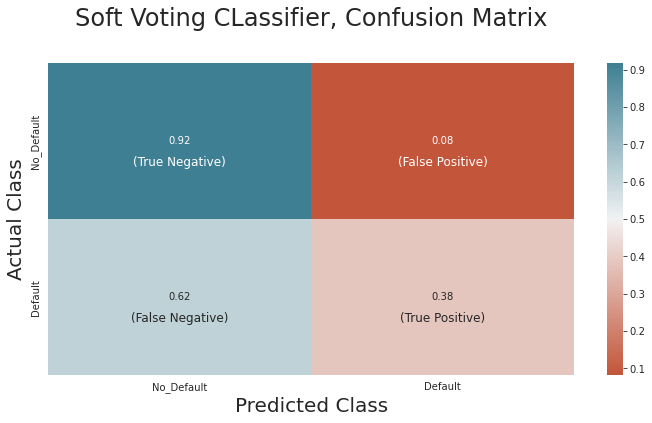

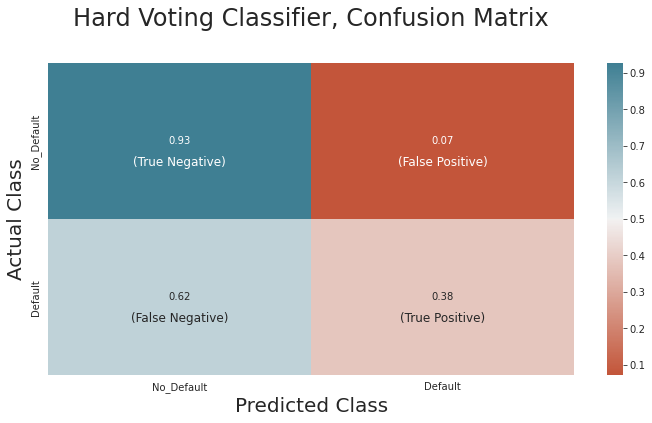

In [10]:
## Confusion Matrix of Hard/Soft VotingCLassifier

#Soft

#print(VCsreport)
cmap = sns.diverging_palette(20, 220, as_cmap=True)
VCscnf_matrix = confusion_matrix(y_test, VCspredictions)
VCscnf_matrixP =VCscnf_matrix.astype('float') / VCscnf_matrix.sum(axis=1)[:, np.newaxis]


class_names=['No_Default','Default'] # name  of classes
fig, ax = plt.subplots(figsize=(10, 6))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
additional_texts = ['(True Negative)', '(False Positive)', '(False Negative)', '(True Positive)']
cmap = sns.diverging_palette(20, 220, as_cmap=True)
# Percentage Confusion Matrix
plt.title('Soft Voting CLassifier, Confusion Matrix', y=1.1, size=24) 
sns.heatmap(VCscnf_matrixP, cmap=cmap, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position("bottom")
ax.yaxis.set_label_position("left")
for text_elt, additional_text in zip(ax.texts, additional_texts):
    ax.text(*text_elt.get_position(), '\n' + additional_text, color=text_elt.get_color(),
            ha='center', va='top', size=12)
ax.set_xlabel('Predicted Class', size=20)
ax.set_ylabel('Actual Class', size=20)
plt.tight_layout()
plt.show()

#Hard Voting
#print(VChreport)
#F2=evalBinaryClassifier(VCh,X_test_trans,y_test) ## Function doesn't work with Hard for whatever reason


VChcnf_matrix = confusion_matrix(y_test, VChpredictions)
VChcnf_matrixP =VChcnf_matrix.astype('float') / VChcnf_matrix.sum(axis=1)[:, np.newaxis]

class_names=['No_Default','Default'] # name  of classes
fig, ax = plt.subplots(figsize=(10, 6))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
additional_texts = ['(True Negative)', '(False Positive)', '(False Negative)', '(True Positive)']


# Percentage Confusion Matrix
plt.title('Hard Voting Classifier, Confusion Matrix', y=1.1, size=24) 

sns.heatmap(VChcnf_matrixP, cmap=cmap, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)

ax.xaxis.set_label_position("bottom")
ax.yaxis.set_label_position("left")
for text_elt, additional_text in zip(ax.texts, additional_texts):
    ax.text(*text_elt.get_position(), '\n' + additional_text, color=text_elt.get_color(),
            ha='center', va='top', size=12)
ax.set_xlabel('Predicted Class', size=20)
ax.set_ylabel('Actual Class', size=20)
plt.tight_layout()
plt.show()


RForest


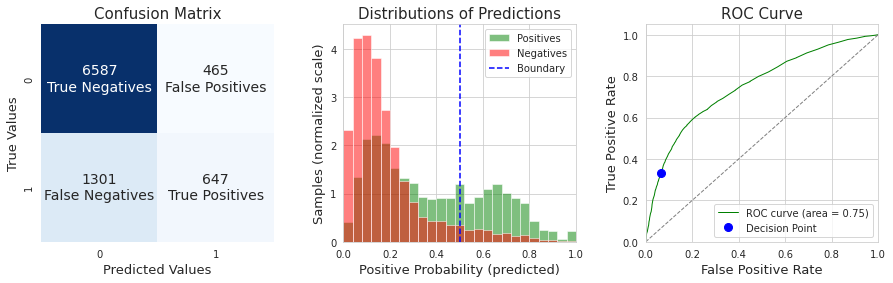

Precision: 0.58 | Recall: 0.33 | F1 Score: 0.42 | 
ADA


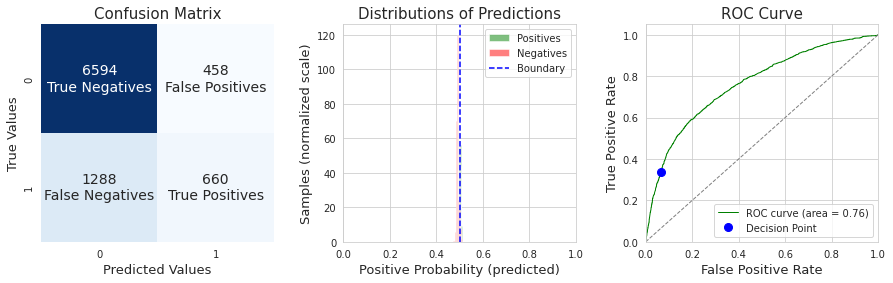

Precision: 0.59 | Recall: 0.34 | F1 Score: 0.43 | 
Gradient Boost


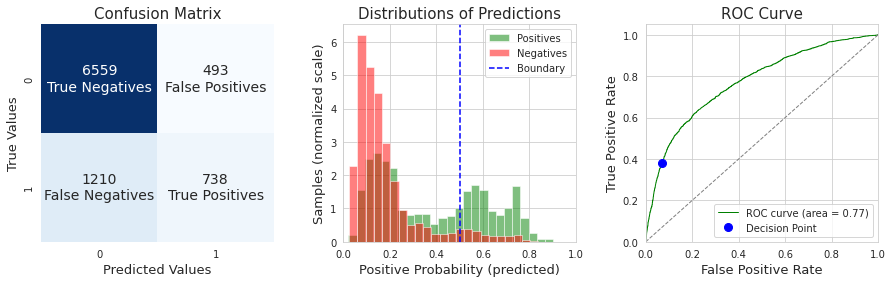

Precision: 0.6 | Recall: 0.38 | F1 Score: 0.46 | 
Decision Tree


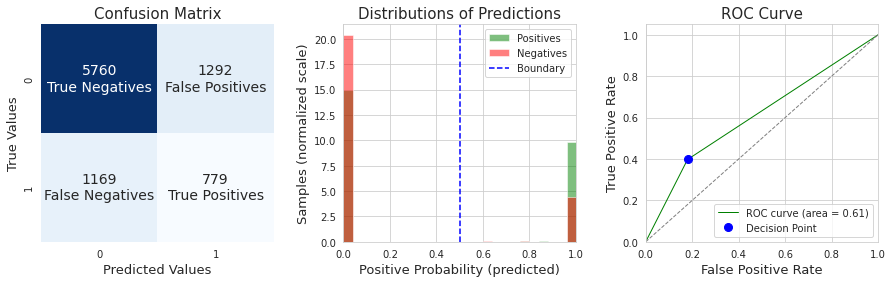

Precision: 0.38 | Recall: 0.4 | F1 Score: 0.39 | 
Logistic Regression


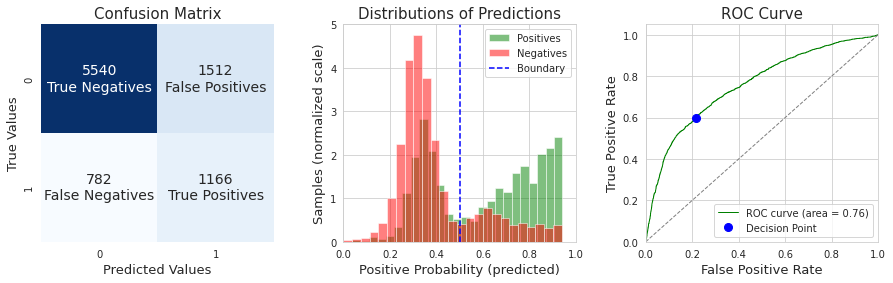

Precision: 0.44 | Recall: 0.6 | F1 Score: 0.5 | 
Soft Voting Classifier


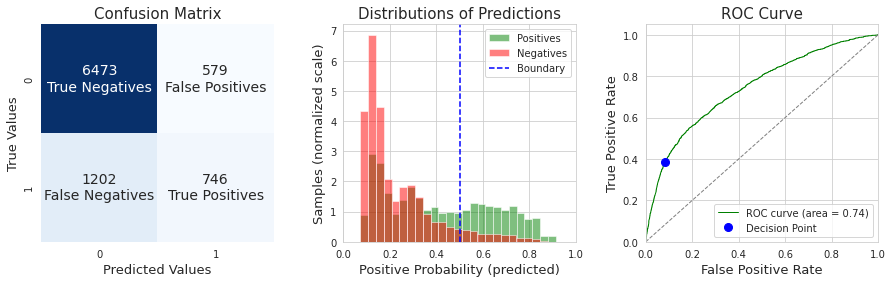

Precision: 0.56 | Recall: 0.38 | F1 Score: 0.46 | 
                  precision    recall  f1-score      support
RF  1              0.581835  0.332136  0.422876  1948.000000
ADA 1              0.590340  0.338809  0.430528  1948.000000
GB  1              0.599513  0.378850  0.464297  1948.000000
VCs 1              0.563019  0.382957  0.455851  1948.000000
DT  1              0.376147  0.399897  0.387659  1948.000000
LR  1              0.435400  0.598563  0.504107  1948.000000
DT  macro avg      0.603718  0.608343  0.605817  9000.000000
RF  macro avg      0.708450  0.633098  0.652335  9000.000000
ADA macro avg      0.713465  0.636931  0.656807  9000.000000
VCs macro avg      0.703203  0.650426  0.667458  9000.000000
GB  macro avg      0.721883  0.654470  0.674696  9000.000000
LR  macro avg      0.655852  0.692078  0.666290  9000.000000
DT  accuracy       0.726556  0.726556  0.726556     0.726556
    weighted avg   0.732776  0.726556  0.729537  9000.000000
LR  weighted avg   0.780873  0.745

In [11]:
## 'Final' Comparison Visualization/Statistics  - CNF_Matrix, Predictions histogram, ROC_AUC curve

print("RForest", )
F1=evalBinaryClassifier(forest,X_test_trans,y_test)
print("ADA")
F2=evalBinaryClassifier(ADA,X_test_trans,y_test)
print("Gradient Boost")
F3=evalBinaryClassifier(GB,X_test_trans,y_test)
print("Decision Tree")
F4=evalBinaryClassifier(DTree,X_test_trans,y_test)
print("Logistic Regression")
F5=evalBinaryClassifier(LR,X_test_trans,y_test)
print("Soft Voting Classifier")
F6=evalBinaryClassifier(VCs,X_test_trans,y_test)

##Optimize for F1/Recall if Want to Minimize False NEgatives 
ClassReports = pd.concat([RFreport,ADAreport,GBreport,DTreport,LRreport,VCsreport], axis=0, 
                         keys=["RF","ADA","GB","DT","LR", "VCs"]) 

print(ClassReports.sort_values('f1-score').sort_values('recall'))

In [12]:
### All models perform significantly better with classifying "non-default" (class 0) than 'default' (class 1)
#### Gradient Boost, ADA, and RF are best overall ('Weighted avg)', sorting first by F1 then recall
#### (Binomial) Logistic regression produced fewest 'false negatives' which is problem CO hopes to avoid!

#### Almost 80% accuracy achieved from the feature-set: 
    ##### ['LIMIT_BAL' 'PAY_2' 'PAY_6' 'BILL_AMT2' 'PAY_AMT2' 'PAY_AMT3'
    ##### 'PAY_AMT4' 'PAY_AMT5' 'PAY_AMT6' 'SEX_male' 'EDUCATION_university'
    ##### 'Debt_Usage6' 'PrevRel' 'Behind1' 'Behind3' 'Behind4' 'Behind5' 'Behind6'
    ##### 'AgeBin2' 'EdRank' 'Slow_Payer' 'High_Lev']

#### Feature Importance varies slightly by model
    #### Customer demographic profile (discretized age, relationship status, even education) appears largely unimportant

### Customers already carrying fair amount of Debt (DU_6), with large recent bills (BILL_AMT2)
### Are higher-risk of default, depending on their timeliness of past payments, especially Sept and Aug

In [13]:
### New Target Y ('Limit_BAL') - Set up loop of regression algorithms, establish baseline accuracies
Reg_Algos = {"Random Forest": RandomForestRegressor(random_state=123),
              "Linear Regression":LinearRegression(n_jobs=10),
              "Support Vector Regression":SVR(),
              "Lasso":linear_model.Lasso(random_state=123),
              "Decision Tree Regression":tree.DecisionTreeRegressor(random_state=123),
              "Ridge Regressor": linear_model.Ridge(alpha=0.5, random_state=123),
               "Bayesian Ridge": linear_model.BayesianRidge(),
              }

n_jobs = 2  # The number of tasks to run in parallel
n_cpus = 2  # Number of CPUs assigned to this process

## Define Custom Scoring Function for RMSE
#root_mean_squared_error = partial(mean_squared_error, squared=False)
#rms_error = make_scorer(root_mean_squared_error)

scoring = ['r2','neg_root_mean_squared_error','neg_mean_absolute_error']

Models=pd.DataFrame(columns=['Name','CrossVal','MAE','RMSE'])
Models2=pd.DataFrame(columns=['Name','CrossVal','MAE','RMSE'])
Models3=pd.DataFrame(columns=['Name','CrossVal','MAE','RMSE'])

### Change Target/Features, Initialize Training Split, Fit & Score for R2, MAE, RMSE

X = Summary.drop(columns=['ID','LIMIT_BAL'])
y = Summary['LIMIT_BAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

### No preprocessing performed

for name, model in Reg_Algos.items():
    model.fit(X_train,y_train)
    result = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
    predictions = model.predict(X_test)
    MAE=mean_absolute_error(y_test,predictions)
    RMSE=sqrt(mean_squared_error(y_test, predictions))
    NewRec={'Name':name, 'CrossVal':result,'MAE':MAE,'RMSE':RMSE}
    Models.loc[len(Models)] = NewRec
    #dump(model, "my_model.pkl")

Models.head(5) ## RForest R2 ~0.4547, LinearRegression and Lasso ~.399


,Name,CrossVal,MAE,RMSE
0,Random Forest,0.457612,65327.549066,94789.469305
1,Linear Regression,0.398874,75202.350541,100145.328248
2,Support Vector Regression,-0.041740,101629.522600,131047.238179
3,Lasso,0.398874,75202.416768,100145.367463
4,Decision Tree Regression,0.001704,85136.090236,129193.894669


In [14]:
# Baseline established above, switch to 'fuller dataset', preprocess X_train, X_test
#'AltSummary' used above for Classification, already hecked for multicollinearity using VIF Threshold 5.0
# AltSummary.info()

X = AltSummary.drop(columns=['ID','LIMIT_BAL'])
y = AltSummary['LIMIT_BAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)
features=X_train.columns

### StandardScaler() PP
scaler = StandardScaler().fit(X_train)
X_train_trans = scaler.transform(X_train)
X_test_trans = scaler.transform(X_test)

for name, model in Reg_Algos.items():
    model.fit(X_train_trans,y_train)
    result = cross_val_score(model, X_train_trans, y_train, cv=5, scoring='r2').mean()
    predictions = model.predict(X_test_trans)
    MAE=mean_absolute_error(y_test,predictions)
    RMSE=sqrt(mean_squared_error(y_test, predictions))
    NewRec={'Name':name, 'CrossVal':result,'MAE':MAE,'RMSE':RMSE}
    Models2.loc[len(Models2)] = NewRec

Models2.head(10) ## R2 for Rforest of ~0.72!! All others (except SVR) are ~0.45

,Name,CrossVal,MAE,RMSE
0,Random Forest,0.719194,40074.261913,67694.382274
1,Linear Regression,0.452542,70495.116677,95115.633272
2,Support Vector Regression,-0.042798,101761.606415,131132.729228
3,Lasso,0.452543,70495.183952,95115.493618
4,Decision Tree Regression,0.436231,53590.851102,94275.713966
5,Ridge Regressor,0.452543,70495.086421,95115.616069
6,Bayesian Ridge,0.452558,70493.641083,95114.816013


In [22]:
##RandomForestRegressor, larger ("AltSummary") Features and RandomizedSearchCV-optimized parameters
X = AltSummary.drop(columns=['ID','LIMIT_BAL'])
y = AltSummary['LIMIT_BAL']

feature_names=X.columns.values
print(feature_names)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

### MinMaxScaler() alternate preprocessing
scaler = MinMaxScaler().fit(X_train)
X_train_trans = scaler.transform(X_train)
X_test_trans = scaler.transform(X_test)

model=RandomForestRegressor(max_depth=12,n_estimators=400,random_state=123)
model.fit(X_train_trans, y_train)
result=cross_validate(model, X_train_trans, y_train, cv=5, scoring=scoring)
predictions = model.predict(X_test_trans)
MAE=mean_absolute_error(y_test,predictions)
RMSE=sqrt(mean_squared_error(y_test, predictions))
#print("RForest",result,"Mean Absolute Error",MAE,"RootMeanSquaredError",RMSE)
#print(result)
NewRec={'Name':name, 'CrossVal':result,'MAE':MAE,'RMSE':RMSE}
print(NewRec)

['PAY_2' 'PAY_6' 'BILL_AMT2' 'PAY_AMT2' 'PAY_AMT3' 'PAY_AMT4' 'PAY_AMT5'
 'PAY_AMT6' 'SEX_male' 'EDUCATION_university' 'def_next_default'
 'Debt_Usage6' 'PrevRel' 'Behind1' 'Behind3' 'Behind4' 'Behind5' 'Behind6'
 'AgeBin2' 'EdRank' 'Slow_Payer' 'High_Lev']
{'Name': 'Bayesian Ridge', 'CrossVal': {'fit_time': array([43.16281843, 40.55525279, 41.4419589 , 45.87976241, 43.33973908]), 'score_time': array([0.29216075, 0.30091381, 0.21834445, 0.35915327, 0.30979371]), 'test_r2': array([0.7093556 , 0.71977612, 0.71499749, 0.71568369, 0.6967568 ]), 'test_neg_root_mean_squared_error': array([-70891.45931757, -69253.75309703, -69917.73793463, -69496.08010288,
       -70084.69771838]), 'test_neg_mean_absolute_error': array([-43741.70777401, -43750.2028887 , -44549.53284133, -42624.07950434,
       -44133.83655445])}, 'MAE': 42076.07425230405, 'RMSE': 68698.7630677939}


In [16]:
##What happens if we drop default from feature set (i.e., since don't know when making LIMIT_BAL decision)
## R2 accuracy drops slightly to ~.71

## What if we again target LImit_BAL, but only against the subset of those who have NOT defaulted before? 
## R2 accuracy drops 


#X = AltSummary.drop(columns=['ID','LIMIT_BAL','def_next_default'])
#y = AltSummary['LIMIT_BAL']

UnkDef = AltSummary.loc[(AltSummary['def_next_default'] == 0)]
X = UnkDef.drop(columns=['ID','LIMIT_BAL','def_next_default'])
y = UnkDef['LIMIT_BAL']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

### MinMaxScaler() alternate preprocessing
scaler = MinMaxScaler().fit(X_train)
X_train_trans = scaler.transform(X_train)
X_test_trans = scaler.transform(X_test)

model=RandomForestRegressor(max_depth=12,n_estimators=400,random_state=123)
model.fit(X_train_trans, y_train)
result=cross_validate(model, X_train_trans, y_train, cv=5, scoring=scoring)
predictions = model.predict(X_test_trans)
MAE=mean_absolute_error(y_test,predictions)
RMSE=sqrt(mean_squared_error(y_test, predictions))
#print("RForest",result,"Mean Absolute Error",MAE,"RootMeanSquaredError",RMSE)
print(result)
#NewRec={'Name':name, 'CrossVal':result,'MAE':MAE,'RMSE':RMSE}
#print(NewRec)

{'fit_time': array([30.6982522 , 30.61142349, 31.71923876, 33.0882318 , 32.43658733]), 'score_time': array([0.20943117, 0.18892193, 0.22874522, 0.25322723, 0.24296021]), 'test_r2': array([0.71339489, 0.70840688, 0.69542009, 0.70174771, 0.68323304]), 'test_neg_root_mean_squared_error': array([-71372.0664071 , -70699.77316775, -73189.20835318, -71845.71744784,
       -73533.00752901]), 'test_neg_mean_absolute_error': array([-45978.14674064, -45238.90429725, -46440.15328705, -46063.59612568,
       -46864.41937038])}


In [17]:
UnkDef.head()

,ID,LIMIT_BAL,PAY_2,PAY_6,BILL_AMT2,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,...,PrevRel,Behind1,Behind3,Behind4,Behind5,Behind6,AgeBin2,EdRank,Slow_Payer,High_Lev
2,3,90000,0,0,14027,1500,1000,1000,1000,5000,...,0,0,0,0,0,0,1,2,0,0
3,4,50000,0,0,48233,2019,1200,1100,1069,1000,...,1,0,0,0,0,0,1,2,0,1
4,5,50000,0,0,5670,36681,10000,9000,689,679,...,1,0,0,0,0,0,3,2,0,0
5,6,50000,0,0,57069,1815,657,1000,1000,800,...,0,0,0,0,0,0,1,3,0,1
6,7,500000,0,0,412023,40000,38000,20239,13750,13770,...,0,0,0,0,0,0,0,3,0,1


In [18]:
### RandomizedSearch CV for Leading Models

n_jobs = 2  # The number of tasks to run in parallel
n_cpus = 2  # Number of CPUs assigned to this process

## Ridge Regressor
RRparams = {'alpha':[0.5,1.0,2.0], 'fit_intercept':['True', 'False'], 'max_iter':[200,500,1000,2000],
            'tol':[1e-3,1e-4,1e-2]}
##Random FOrest
RFparams = {'n_estimators':[50,100,200,400], 'max_depth':[6,8,10,12,None], 'min_samples_leaf':[200,400,600,800,1000,1200],
               'criterion':['squared_error']}
## Ordinary Least Squares Linear Regression
LSOparams = {'fit_intercept':['True', 'False'], 'alpha':[0.5,1.0,2.0,4.0], 'max_iter':[200,500,1000,2000],
               'selection':['cyclic','random']}

X = AltSummary.drop(columns=['ID','LIMIT_BAL'])
y = AltSummary['LIMIT_BAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

scaler = StandardScaler().fit(X_train)
X_train_trans = scaler.transform(X_train)
X_test_trans = scaler.transform(X_test)

##Change CLF for each of three model types

clf=RandomizedSearchCV(RandomForestRegressor(random_state=123, n_jobs=n_jobs),RFparams,cv=5,
                       n_iter=30,scoring='neg_root_mean_squared_error', verbose=3)
clf.fit(X_train_trans,y_train)
y_test, y_pred = y_test, clf.predict(X_test_trans)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END criterion=squared_error, max_depth=6, min_samples_leaf=400, n_estimators=400;, score=-96681.970 total time=  11.1s
[CV 2/5] END criterion=squared_error, max_depth=6, min_samples_leaf=400, n_estimators=400;, score=-93393.436 total time=  11.3s
[CV 3/5] END criterion=squared_error, max_depth=6, min_samples_leaf=400, n_estimators=400;, score=-94449.647 total time=  11.5s
[CV 4/5] END criterion=squared_error, max_depth=6, min_samples_leaf=400, n_estimators=400;, score=-93809.987 total time=   9.9s
[CV 5/5] END criterion=squared_error, max_depth=6, min_samples_leaf=400, n_estimators=400;, score=-92706.787 total time=  11.2s
[CV 1/5] END criterion=squared_error, max_depth=6, min_samples_leaf=600, n_estimators=200;, score=-99944.553 total time=   4.9s
[CV 2/5] END criterion=squared_error, max_depth=6, min_samples_leaf=600, n_estimators=200;, score=-96331.040 total time=   5.3s
[CV 3/5] END criterion=squared_error, max_

[CV 5/5] END criterion=squared_error, max_depth=6, min_samples_leaf=600, n_estimators=50;, score=-94994.497 total time=   1.4s
[CV 1/5] END criterion=squared_error, max_depth=10, min_samples_leaf=800, n_estimators=200;, score=-101770.187 total time=   4.7s
[CV 2/5] END criterion=squared_error, max_depth=10, min_samples_leaf=800, n_estimators=200;, score=-98171.303 total time=   5.3s
[CV 3/5] END criterion=squared_error, max_depth=10, min_samples_leaf=800, n_estimators=200;, score=-99166.292 total time=   5.3s
[CV 4/5] END criterion=squared_error, max_depth=10, min_samples_leaf=800, n_estimators=200;, score=-98725.145 total time=   3.7s
[CV 5/5] END criterion=squared_error, max_depth=10, min_samples_leaf=800, n_estimators=200;, score=-96719.804 total time=   4.2s
[CV 1/5] END criterion=squared_error, max_depth=10, min_samples_leaf=1000, n_estimators=100;, score=-103561.880 total time=   2.2s
[CV 2/5] END criterion=squared_error, max_depth=10, min_samples_leaf=1000, n_estimators=100;, sc

[CV 4/5] END criterion=squared_error, max_depth=12, min_samples_leaf=600, n_estimators=100;, score=-97047.328 total time=   2.4s
[CV 5/5] END criterion=squared_error, max_depth=12, min_samples_leaf=600, n_estimators=100;, score=-95111.241 total time=   2.5s
[CV 1/5] END criterion=squared_error, max_depth=12, min_samples_leaf=400, n_estimators=100;, score=-96688.221 total time=   2.8s
[CV 2/5] END criterion=squared_error, max_depth=12, min_samples_leaf=400, n_estimators=100;, score=-93400.934 total time=   3.2s
[CV 3/5] END criterion=squared_error, max_depth=12, min_samples_leaf=400, n_estimators=100;, score=-94437.817 total time=   3.0s
[CV 4/5] END criterion=squared_error, max_depth=12, min_samples_leaf=400, n_estimators=100;, score=-93760.010 total time=   2.7s
[CV 5/5] END criterion=squared_error, max_depth=12, min_samples_leaf=400, n_estimators=100;, score=-92757.926 total time=   2.8s
[CV 1/5] END criterion=squared_error, max_depth=12, min_samples_leaf=1000, n_estimators=100;, sco

In [24]:
print('Best model was', clf.best_estimator_, 'with score of', clf.best_score_)
CVresults=clf.cv_results_
CV=pd.DataFrame(CVresults)
print(CV.sort_values('mean_test_score', ascending=False))
print(clf.scorer_,clf.n_features_in_, clf.best_estimator_.score)


Best model was RandomForestRegressor(min_samples_leaf=200, n_estimators=400, n_jobs=2,
                      random_state=123) with score of -88951.8029468877
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
23      13.276962      1.377081         0.126862        0.014074   
20       6.656545      0.731846         0.076693        0.005940   
19       3.157592      0.470165         0.038785        0.005321   
10       3.472677      0.487580         0.037030        0.006085   
6        3.224634      0.242956         0.033377        0.005157   
24      11.559490      0.402966         0.127986        0.009933   
29       5.083366      0.462896         0.060680        0.006231   
7        5.478514      0.693615         0.068856        0.008366   
0       10.893184      0.553553         0.119070        0.023833   
26       2.875586      0.180451         0.030639        0.004348   
22       3.101668      0.208797         0.036798        0.002454   
21       1.529758      0.

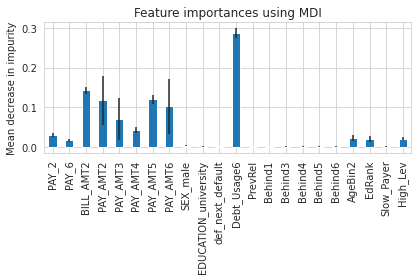

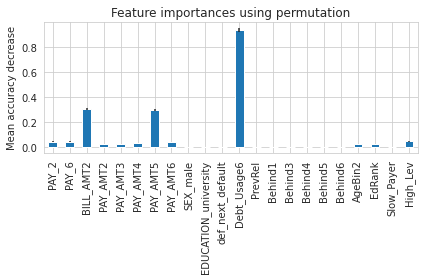

In [23]:
feature_names=X.columns.values
#print(feature_names)

## RForest - Based on mean decrease in impurity
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
model_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
model_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
#model_importances.nlargest(4).plot(kind='barh')

## RForest - Based on Permutation Importance
result = permutation_importance(model, X_test_trans, y_test, n_repeats=10, random_state=42, n_jobs=1)
model_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots()
model_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
X = Summary.drop(columns=['ID','LIMIT_BAL'])
y = Summary['LIMIT_BAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

### Preprocessing Method 2: MinMaxScaler()
scaler = MinMaxScaler().fit(X_train)
X_train_trans = scaler.transform(X_train)
X_test_trans = scaler.transform(X_test)

for name, model in algos_Class.items():
    model.fit(X_train_trans,y_train)
    result = cross_val_score(model, X_train_trans, y_train, cv=5, scoring='r2').mean()
    predictions = model.predict(X_test_trans)
    MAE=mean_absolute_error(y_test,predictions)
    RMSE=sqrt(mean_squared_error(y_test, predictions))
    NewRec={'Name':name, 'CrossVal':result,'MAE':MAE,'RMSE':RMSE}
    Models3.loc[len(Models3)] = NewRec

Models3.head(10) ## RForest R2 ~0.455, LinearRegression, RideRegressor, Bayesian Ridge, Lasso ~.399
## SVM -0.04 and DTree Regression -0.008

In [ ]:
#### For 'Summary'

##RandomizedSearchCV, 30 iterations totalling 150 folds --> R2 score 0.4588
##with optimal parameters max_depth=10, min_samples_leaf=200, and n_estimators = 50

### GridSearchCV (using above parameter set), also max_depth=10, min_samples_leaf=200

## Based on AltSummary, Optimal parameters 
## max_depth=12,min_samples_leaf=200, n_estimators=400

In [ ]:
## In case need to load previously run models
clf=load("GridSearch-RForest.joblib")
print('Best model was', clf.best_estimator_, 'with score of', clf.best_score_)